# 🚀 Day 4-2:  AutoML 스프린트 with PyCaret 🏎️

지금까지 우리는 머신러닝 모델을 만들기 위해 데이터 전처리, 모델 선택, 하이퍼파라미터 튜닝 등 수많은 단계를 직접 코드로 구현해왔습니다.

이 과정은 매우 중요하지만, 때로는 반복적이고 많은 시간을 소요하기도 합니다.

만약 이 복잡한 과정의 상당 부분을 자동화할 수 있다면 어떨까요? <u>AutoML(Automated Machine Learning)</u> 은 바로 이 질문에서 시작된 기술입니다. 

AutoML은 머신러닝 모델 개발의 반복적인 과정을 자동화하여, 데이터 사이언티스트가 모델링의 본질적인 문제 해결에 더 집중할 수 있도록 돕습니다. 

특히 초보자나 비전문가도 복잡한 알고리즘 선택이나 하이퍼파라미터 튜닝을 직접 수행하지 않고도 빠르고 쉽게 준수한 성능의 모델을 만들 수 있다는 큰 장점이 있습니다. 

이번 시간에는 파이썬의 대표적인 AutoML 라이브러리인 <u>PyCaret</u>을 사용하여 머신러닝 '스프린트'를 경험해볼 것입니다. 

PyCaret은 <u>"Low-Code"(코드 최소화)</u> 컨셉을 지향하는 라이브러리로, 단 몇 줄의 코드로 데이터 준비부터 모델 학습, 성능 비교, 튜닝, 배포까지 전 과정을 수행할 수 있게 해줍니다. 

### 학습 목표

1. AutoML과 PyCaret의 핵심 개념을 이해합니다.
   
2. <u>`setup()`</u> 함수로 머신러닝 실험 환경을 자동으로 설정합니다.
3. <u>`compare_models()`</u> 함수로 수많은 모델을 한 번에 학습하고 성능 <u>리더보드</u>를 확인합니다.
4. <u>`blend_models()`</u>, <u>`stack_models()`</u> 등 <u>자동 앙상블(스태킹)</u> 기법을 활용하여 성능을 추가로 개선합니다.
5. 완성된 모델 파이프라인을 저장하고 불러오는 방법을 익힙니다.

### 데이터셋: 서울시 따릉이 자전거 대여 수요 예측

이번 실습에서는 공개된 서울시 공공자전거(따릉이) 대여 수요 데이터를 사용합니다. 

특정 날짜의 시간, 기온, 강수량 등 여러 환경 요소를 바탕으로 해당 시간의 자전거 대여 수를 예측하는 <u>AutoML(Automated Machine Learning)</u> 문제입니다.

In [1]:
# PyCaret 설치 (python 3.9, 3.10, 3.11 환경에서만 동작합니다. 환경 준비가 어려우신 분은 강사가 제공한 Docker 환경을 사용하세요.)
# 이미지 빌드 및 컨테이너 실행 : docker compose -f docker/automl/docker-compose.yml up -d --build
# 주피터노트북 접속 주소 : http://localhost:8892 암호없음

# !pip install pycaret -q

In [2]:
# 필요한 라이브러리 임포트
import pandas as pd
from pycaret.regression import *

# 데이터셋 URL (도커 / 로컬 환경에 따라 경로를 변경하세요)
path = './datasets/ml/bike-sharing/SeoulBikeData.csv'

# 데이터 불러오기 
df = pd.read_csv(path, encoding='cp949')

# 컬럼명에서 특수문자 및 공백 제거
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

# Date 컬럼을 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

print("데이터 크기:", df.shape)
df.head()

데이터 크기: (8760, 14)


,Date,RentedBikeCount,Hour,Temperature,Humidity,Windspeedms,Visibility10m,Dewpointtemperature,SolarRadiationMJm2,Rainfallmm,Snowfallcm,Seasons,Holiday,FunctioningDay
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


---

### 1. PyCaret 환경 설정 - `setup()`

#### 🧠 개념 이해하기

PyCaret 워크플로우의 첫 단추이자 가장 중요한 함수는 <u>setup()</u> 입니다.

이 함수 하나가 수많은 작업을 자동으로 처리해줍니다.

- 각 컬럼의 데이터 타입을 자동으로 인식합니다 (Numeric, Categorical, Datetime 등).
  
- 결측값 처리 (숫자는 평균, 범주형은 최빈값 등) , 범주형 데이터 인코딩 (원-핫 인코딩 등) , 데이터 분할 (Train/Test Split)  등 모델 학습에 필요한 전처리 과정을 내부적으로 구성합니다.
- `session_id`를 지정하여 모든 과정의 랜덤성을 통제함으로써 실험 결과를 재현할 수 있게 합니다. 

`setup()` 함수에 원본 데이터프레임과 타겟 변수 이름만 알려주면, PyCaret이 나머지를 마법처럼 처리하는 것을 볼 수 있습니다.

In [3]:
# PyCaret 회귀 실험 환경 설정
reg_exp = setup(
    data=df,                      # 원본 데이터프레임
    target='RentedBikeCount',     # 예측할 타겟 변수
    session_id=123,               # 결과 재현을 위한 시드값
    train_size=0.8,               # 훈련 데이터 비율 (기본값 0.7)
    normalize=True,               # 특성 스케일링(정규화) 적용
    date_features=['Date']        # 날짜 타입으로 처리할 컬럼
)

print("✅ PyCaret 설정이 완료되었습니다.")

,Description,Value
0,Session id,123
1,Target,RentedBikeCount
2,Target type,Regression
3,Original data shape,"(8760, 14)"
4,Transformed data shape,"(8760, 19)"
5,Transformed train set shape,"(7008, 19)"
6,Transformed test set shape,"(1752, 19)"
7,Numeric features,9
8,Date features,1
9,Categorical features,3


✅ PyCaret 설정이 완료되었습니다.


`setup()`을 실행하면 PyCaret이 자동으로 처리한 내용들이 표 형태로 출력됩니다. 

훈련/테스트 데이터의 크기, 타겟 변수의 이름, 원본 데이터의 특성 수, 그리고 각 특성이 어떤 타입으로 인식되었고 어떤 전처리(예: 결측치 처리, 정규화)가 적용될 예정인지 한눈에 파악할 수 있습니다.

#### ✏️ 연습문제 1

`setup()` 함수를 다시 호출하여 새로운 실험 환경 `reg_exp_2`를 만들어보세요. 아래 조건을 적용하세요.
- `train_size`를 `0.75`로 변경
- `normalize` 옵션을 `False`로 변경
- `session_id`는 `456`으로 설정

In [4]:
# 여기에 코드를 작성하세요
# reg_exp_2 = setup(...)

---

### 2. 모델 훈련 및 비교 - `compare_models()`

#### 🧠 개념 이해하기

환경 설정이 끝났다면, 이제 본격적으로 모델링을 시작할 차례입니다. 

AutoML 함수 `compare_models()`는 PyCaret의 하이라이트 기능으로, 
 
라이브러리에 내장된 모든 모델(회귀의 경우 Linear Regression, Random Forest, XGBoost, LightGBM 등 20개 이상)을 자동으로 훈련하고 비교해줍니다.

이 함수 하나로 우리는 다음과 같은 이점을 얻습니다.

- <u>`Low-Code`</u>: 수많은 모델을 일일이 코딩할 필요 없이 한 줄의 코드로 실행 가능 
  
- <u>`객관적 평가`</u>: 모든 모델이 동일한 데이터 분할과 교차 검증 전략 하에 평가되므로 공정한 비교가 가능합니다.
- <u>`전체 모니터링`</u>: MAE, RMSE, R² 등 주요 평가지표가 계산된 표(리더보드)가 출력되어 어떤 모델이 가장 우수한지 즉시 확인할 수 있습니다. 

`compare_models()`가 반환하는 값은 리더보드에서 가장 성능이 좋은 모델 객체입니다. 

In [5]:
# 모든 모델을 훈련하고 성능을 비교합니다.
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,129.9259,42817.8344,206.5726,0.8979,0.8933,0.4717,0.7510
lightgbm,Light Gradient Boosting Machine,131.3876,44686.4516,211.0143,0.8935,0.8724,0.4805,3.4350
et,Extra Trees Regressor,127.0321,45740.5389,213.3954,0.8909,0.5244,0.4743,0.1370
xgboost,Extreme Gradient Boosting,134.6547,46897.7426,216.2890,0.8881,0.9149,0.5207,0.0180
rf,Random Forest Regressor,133.5596,48843.6032,220.6908,0.8835,0.6341,0.4895,0.2810
gbr,Gradient Boosting Regressor,166.6767,62565.8619,249.9354,0.8508,1.0038,0.7347,0.0770
knn,K Neighbors Regressor,192.6795,90733.1075,300.9924,0.7838,0.5933,0.6935,0.0120
dt,Decision Tree Regressor,177.0762,96054.9920,309.7430,0.7710,0.6203,0.5625,0.0120
ada,AdaBoost Regressor,356.2889,172640.7186,415.2960,0.5888,1.5174,2.3959,0.0420
ridge,Ridge Regression,323.0624,187473.6975,432.8901,0.5539,1.3448,1.6481,0.0080


In [6]:
# 가장 성능이 좋은 모델(리더보드 1위)을 확인합니다.
print(best_model)

리더보드를 보면 수많은 모델들이 R²(결정계수) 기준으로 정렬되어 있으며, 가장 높은 점수를 받은 모델이 하이라이트 표시됩니다. 위 예시에서는 LightGBM (`lightgbm`)이 가장 좋은 성능을 보였을 가능성이 높습니다. (결과는 실행 환경이나 버전에 따라 다를 수 있습니다.)

#### ✏️ 연습문제 2

`compare_models()` 함수를 다시 실행하되, 이번에는 성능 평가 기준을 R²가 아닌 <u>RMSE</u>로 변경하여 리더보드를 정렬해보세요.

(힌트: `sort` 파라미터를 사용합니다. RMSE는 낮을수록 좋은 지표입니다.)

In [7]:
# 여기에 코드를 작성하세요
# best_rmse_model = compare_models(...)

---

### 3. 개별 모델 생성, 튜닝, 분석

#### 🧠 개념 이해하기

`compare_models()`로 유망한 모델 후보군을 찾았다면, 이제 특정 모델을 더 깊이 파고들 차례입니다.



PyCaret에서는 `compare_models()`로 전체적인 성능 비교를 마친 후, 특정 모델에 대해 더 세밀한 작업을 수행할 수 있습니다

**1. 개별 모델 생성 (`create_model`)**
- 특정 알고리즘을 명시적으로 선택하여 모델을 생성합니다
- 예: `create_model('lightgbm')`, `create_model('rf')` 등

**2. 하이퍼파라미터 튜닝 (`tune_model`)**
- 생성된 모델의 성능을 최적화하기 위해 하이퍼파라미터를 자동으로 조정합니다
- 그리드 서치, 랜덤 서치 등의 방법을 내부적으로 사용합니다

**3. 모델 성능 분석 (`plot_model`)**
- 다양한 시각화를 통해 모델의 성능과 특성을 분석할 수 있습니다
- 잔차 플롯, 특성 중요도, 학습 곡선 등 다양한 플롯을 제공합니다

이제 실제로 이 과정들을 단계별로 실습해보겠습니다.


In [8]:
# compare_models에서 1위를 차지한 catboost 모델을 명시적으로 생성합니다.
catb = create_model('catboost') 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,131.6455,43728.9900,209.1148,0.8966,0.8996,0.3859
1,141.0710,48169.9300,219.4765,0.8835,0.9609,0.5459
2,122.7334,38623.9737,196.5298,0.9119,0.9159,0.4880
3,120.3460,36599.7579,191.3106,0.9163,0.8450,0.4712
4,132.9811,47448.0102,217.8256,0.8803,0.7223,0.4048
5,119.8700,35414.9564,188.1886,0.9160,0.8815,0.4323
6,134.6275,47409.6113,217.7375,0.8905,0.9748,0.4044
7,125.0237,38992.7095,197.4657,0.9048,0.9509,0.6333
8,139.5330,49788.3894,223.1331,0.8842,0.8459,0.4347


In [9]:
# 생성한 catboost 모델의 하이퍼파라미터를 튜닝합니다.
tuned_catb = tune_model(catb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,134.7907,44019.8339,209.8090,0.8959,0.9151,0.3780
1,141.2682,50508.4166,224.7408,0.8778,0.9234,0.5345
2,125.0917,37978.3977,194.8805,0.9134,0.9309,0.5760
3,122.0597,35703.7065,188.9542,0.9184,0.8773,0.5260
4,144.1429,50866.2461,225.5355,0.8717,0.8325,0.4810
5,126.0068,39345.1079,198.3560,0.9067,0.9312,0.4413
6,135.6260,49014.8928,221.3931,0.8868,0.9314,0.4663
7,129.4869,40819.1392,202.0375,0.9003,0.9167,0.6269
8,143.6091,51913.9817,227.8464,0.8793,0.8483,0.4217


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


#### 📊 모델 성능 시각화
튜닝된 모델의 성능을 `plot_model`을 통해 시각적으로 분석해봅시다.

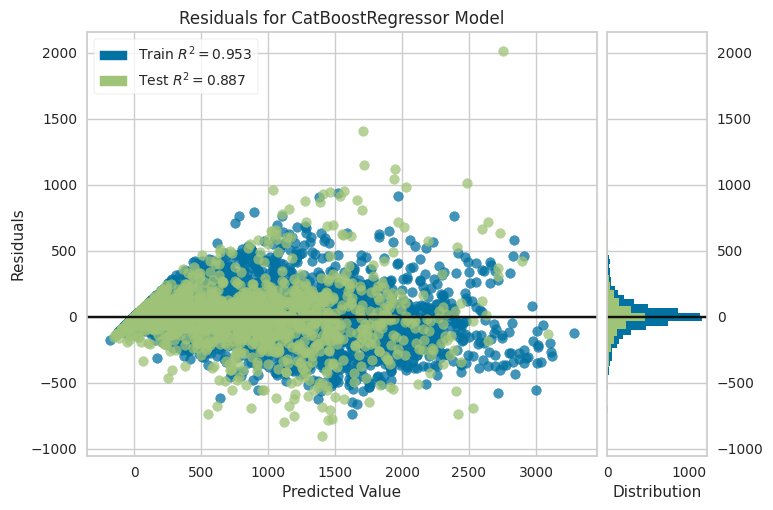

In [10]:
# 잔차 플롯 (Residuals Plot)
# 좋은 모델이라면 잔차가 0을 중심으로 특별한 패턴 없이 무작위로 분포해야 합니다.
plot_model(tuned_catb, plot='residuals')

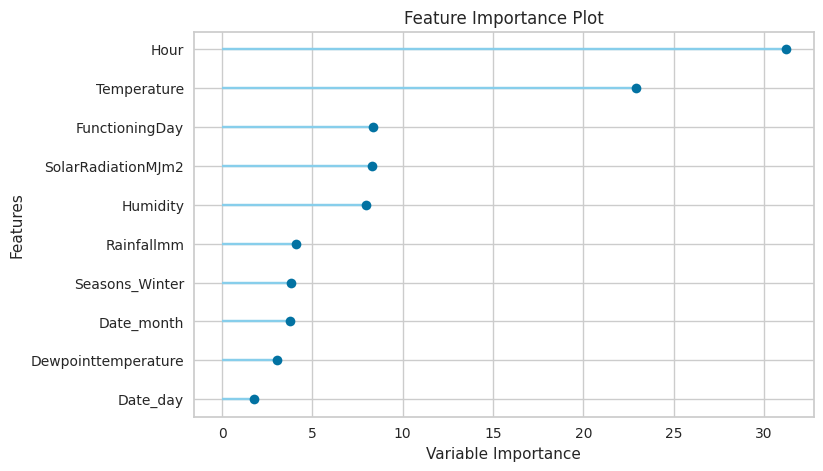

In [11]:
# 특성 중요도 플롯 (Feature Importance Plot)
# 모델이 예측을 수행할 때 어떤 특성을 중요하게 사용했는지 보여줍니다.
plot_model(tuned_catb, plot='feature')

#### ✏️ 연습문제 3

이번에는 PyCaret을 이용해서 다음 작업을 수행해보세요.
1. `create_model()` 함수로 'rf' 모델을 생성하고 `rf_model` 변수에 저장하세요.
2. 생성된 `rf_model`을 `tune_model()`로 튜닝하여 `tuned_rf` 변수에 저장하세요.
3. 튜닝된 `tuned_rf` 모델의 <u>PyCaret</u> 플롯을 그려보세요.

In [12]:
# 1. 'rf' 모델 생성
# rf_model = ...

# 2. 모델 튜닝
# tuned_rf = ...

# 3. 예측 오차 플롯
# plot_model(...)

---
### 4. 자동 앙상블 모델링 (Blending & Stacking)

#### 🧠 개념 이해하기

여러 모델의 예측을 결합하면 단일 모델보다 더 강력한 성능을 내는 경우가 많습니다. 

앞서 여러차례 배운 <u>앙상블(Ensemble)</u> 기법이 필요합니다.

PyCaret은 복잡한 앙상블 모델을 매우 쉽게 만들 수 있는 함수들을 제공합니다.

- <u>블렌딩(Blending)</u>: 여러 모델의 예측값을 단순 평균(회귀) 또는 확률 평균(분류)하여 최종 예측을 만듭니다. 빠르고 간단하게 성능을 개선할 수 있습니다.
- <u>스태킹(Stacking)</u>: 여러 기본 모델들의 예측값을 새로운 '특성'으로 사용하여, `메타 모델(Meta Model)` 이라 불리는 최종 모델을 한 번 더 학습시킵니다. 일반적으로 블렌딩보다 더 정교하고 높은 성능을 기대할 수 있습니다.

PyCaret의 `blend_models()`와 `stack_models()` 함수가 바로 이 기능들을 제공합니다.

In [13]:
# compare_models() 결과에서 상위 3개 모델을 선택합니다.
top3 = compare_models(n_select=3)
print("Top 3 모델:", top3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,129.9259,42817.8344,206.5726,0.8979,0.8933,0.4717,0.6020
lightgbm,Light Gradient Boosting Machine,131.3876,44686.4516,211.0143,0.8935,0.8724,0.4805,3.8720
et,Extra Trees Regressor,127.0321,45740.5389,213.3954,0.8909,0.5244,0.4743,0.1500
xgboost,Extreme Gradient Boosting,134.6547,46897.7426,216.2890,0.8881,0.9149,0.5207,0.0250
rf,Random Forest Regressor,133.5596,48843.6032,220.6908,0.8835,0.6341,0.4895,0.2480
gbr,Gradient Boosting Regressor,166.6767,62565.8619,249.9354,0.8508,1.0038,0.7347,0.0880
knn,K Neighbors Regressor,192.6795,90733.1075,300.9924,0.7838,0.5933,0.6935,0.0100
dt,Decision Tree Regressor,177.0762,96054.9920,309.7430,0.7710,0.6203,0.5625,0.0190
ada,AdaBoost Regressor,356.2889,172640.7186,415.2960,0.5888,1.5174,2.3959,0.0510
ridge,Ridge Regression,323.0624,187473.6975,432.8901,0.5539,1.3448,1.6481,0.0080


Top 3 모델: [<catboost.core.CatBoostRegressor object at 0xffff0da5bb10>, LGBMRegressor(n_jobs=-1, random_state=123), ExtraTreesRegressor(n_jobs=-1, random_state=123)]


In [14]:
# 3개 모델을 블렌딩합니다.
blended_model = blend_models(estimator_list=top3)
print("블렌딩된 모델:", blended_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,124.2677,42119.2295,205.2297,0.9004,0.7883,0.3539
1,135.3504,46764.6245,216.2513,0.8869,0.8484,0.4893
2,114.5503,36128.6953,190.0755,0.9176,0.8314,0.5157
3,114.5951,34560.2766,185.9039,0.9210,0.7623,0.4441
4,129.4530,46781.2622,216.2898,0.8820,0.6464,0.3659
5,112.8786,34506.8526,185.7602,0.9182,0.7758,0.3840
6,127.2881,45574.1141,213.4809,0.8947,0.8226,0.3830
7,120.4901,39488.1248,198.7162,0.9036,0.8083,0.5658
8,136.3758,50586.9516,224.9154,0.8824,0.7485,0.4144


블렌딩된 모델: VotingRegressor(estimators=[('CatBoost Regressor',
                             <catboost.core.CatBoostRegressor object at 0xffff0dd6f4d0>),
                            ('Light Gradient Boosting Machine',
                             LGBMRegressor(n_jobs=-1, random_state=123)),
                            ('Extra Trees Regressor',
                             ExtraTreesRegressor(n_jobs=-1, random_state=123))],
                n_jobs=-1)


In [15]:
# 2, 3위 모델(estimator_list) 위에 1위 모델(meta_model)을 쌓아 스태킹합니다.
# estimator_list는 튜닝된 모델도 포함할 수 있습니다.
stacked_model = stack_models(estimator_list=top3[1:], meta_model=top3[0])
print("스태킹된 모델:", stacked_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,124.3308,43953.0382,209.6498,0.8961,0.4969,0.3372
1,137.7897,50367.0604,224.4261,0.8781,0.5523,0.4749
2,120.4600,42618.2325,206.4418,0.9028,0.5576,0.5270
3,120.5099,40514.7099,201.2827,0.9074,0.5169,0.4064
4,133.9375,49602.7241,222.7167,0.8749,0.4850,0.3520
5,114.4283,37629.2580,193.9826,0.9108,0.5560,0.3632
6,127.5666,47357.2059,217.6171,0.8906,0.5070,0.3597
7,122.7588,40958.5314,202.3821,0.9000,0.5455,0.5843
8,139.7369,57467.0346,239.7228,0.8664,0.5265,0.4070


스태킹된 모델: StackingRegressor(cv=5,
                  estimators=[('Light Gradient Boosting Machine',
                               LGBMRegressor(n_jobs=-1, random_state=123)),
                              ('Extra Trees Regressor',
                               ExtraTreesRegressor(n_jobs=-1,
                                                   random_state=123))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0xffff0d520290>,
                  n_jobs=-1)


#### ✏️ 연습문제 4

`compare_models()`를 이용해 성능 상위 5개 모델을 찾아 `top5` 변수에 저장하고, 이 5개 모델 전체를 `blend_models()` 함수로 블렌딩하여 `blended_top5` 라는 모델을 만들어보세요.

In [16]:
# 여기에 코드를 작성하세요
# top5 = ...
# blended_top5 = ...

---
### 5. 모델 최종화, 평가 및 저장

#### 🧠 개념 이해하기

최고의 모델(또는 앙상블 모델)을 찾았다면, 이제 실전에 투입할 수 있도록 모델을 완성하고 저장해야 합니다.

- `predict_model()`: 선택한 모델의 성능을 테스트 데이터에 대해 최종 평가합니다. 지금까지 교차 검증에서 보았던 성능이 보지 못했던 새로운 데이터에서도 잘 유지되는지 확인하는 중요한 단계입니다.
  
- `finalize_model()`: 모델을 전체 데이터셋(훈련 + 테스트)으로 다시 학습시킵니다. 더 많은 데이터를 학습하여 모델의 성능을 극한까지 끌어올리는 과정입니다.
- `save_model()`: 최종 학습된 모델 객체와 전처리 파이프라인 전체를 하나의 `.pkl` 파일로 저장합니다. 
- `load_model()`: 이렇게 저장된 파일은 나중에 load_model()로 불러와 새로운 데이터에 대한 예측을 바로 수행하는 데 사용될 수 있습니다.

In [17]:
# 지금까지 만든 모델 중 가장 성능이 좋았던 블랜딩 모델의 최종 성능을 확인합니다. (여러분의 결과와 다른 모델일 수 있습니다.)
predictions = predict_model(blended_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,123.2881,44476.3020,210.8941,0.8882,0.8057,0.3609


In [18]:
# 블렌딩 모델을 전체 데이터로 다시 학습하여 최종 모델을 만듭니다.
final_model = finalize_model(blended_model)
print("최종 모델:", final_model)

최종 모델: Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['Date'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['Hour', 'Temperature', 'Humidity',
                                             'Windspeedms', 'Visibility10m',
                                             'Dewpointtemperature',
                                             'SolarRadiationMJm2', 'Rainfallmm',
                                             'Snowfallcm'],
                                    transformer=SimpleImpu...
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 VotingRegressor(estimators=[('CatBoost Regressor',
                                              <catboost.core.CatBoostRegressor object at 0xffff0d8d09d0>),
                     

In [19]:
# 완성된 최종 모델을 파일로 저장합니다.
save_model(final_model, './models/seoul_bike_demand_model')
print("✅ 모델이 'seoul_bike_demand_model.pkl' 파일로 저장되었습니다.")

Transformation Pipeline and Model Successfully Saved
✅ 모델이 'seoul_bike_demand_model.pkl' 파일로 저장되었습니다.


In [20]:
# 저장된 모델 불러오기 시연
loaded_model = load_model('./models/seoul_bike_demand_model')
print("불러온 모델:", loaded_model)

Transformation Pipeline and Model Successfully Loaded
불러온 모델: Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['Date'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['Hour', 'Temperature', 'Humidity',
                                             'Windspeedms', 'Visibility10m',
                                             'Dewpointtemperature',
                                             'SolarRadiationMJm2', 'Rainfallmm',
                                             'Snowfallcm'],
                                    transformer...
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 VotingRegressor(estimators=[('CatBoost Regressor',
                                              <catboost.core.CatBoostRegr

#### ✏️ 연습문제 5

연습문제 4에서 만들었던 `blended_top5` 모델에 대해 다음 작업을 수행하세요.
1. `predict_model()`을 사용해 `blended_top5` 모델의 테스트 데이터 성능을 확인하세요.
2. `finalize_model()`을 사용해 `blended_top5` 모델을 최종화하고 `final_blended_model` 변수에 저장하세요.
3. `save_model()`을 사용해 `final_blended_model`을 `blended_bike_model` 이라는 이름으로 저장하세요.

In [21]:
# blended_top5 모델이 정의되어 있다고 가정합니다.
# top5 = compare_models(n_select = 5)
# blended_top5 = blend_models(top5)

# 1. 모델 성능 평가
# predict_model(...)

# 2. 모델 최종화
# final_blended_model = ...

# 3. 모델 저장
# save_model(...)